In [109]:
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import matplotlib.pyplot as plt
from models import PriceModel
import pandas as pd
import numpy as np
import fetch_data
import math
plt.style.use(['seaborn-dark'])

I_START_DATE = datetime(2010, 1, 1)
I_END_DATE = datetime(2014, 12, 31)
START_DATE = datetime(2015, 1, 1)
END_DATE = datetime(2016, 4, 1)

## Load Data

Load all the tickers within the S&P 500. Download data using Yahoo Finance API. Save data in pickled dataframe.

In [110]:
sp500_tickers = []
with open('sp500_tickers.csv', 'r') as f:
    sp500_tickers = f.readlines()[0].split('\r')

In [111]:
"""Only run if data is not already downloaded
# As this is very time consuming
"""
# master_data = fetch_data.fetch_multi(sp500_tickers, '2010-01-01', '2016-04-30')
# master_data.to_pickle('master_data.pkl')

'Only run if data is not already downloaded\n# As this is very time consuming\n'

In [112]:
# Load pickled master data file if it exists
master_data = pd.read_pickle('master_data.pkl')

## Define Technical Indicators

The following technical indicators will be used as features for training the model.

1.  Simple Moving Average (SMA)
2.  Bollinger Bands
3.  Momentum -
4.  RSI
5.  William %R
6.  MACD
7.  Standard Deviation


In [113]:
def calc_sma(prices, window=30):
    """Returns a Simple Moving Average"""
    return prices['prices'].rolling(window=window).mean()

def calc_bollinger_bands(prices, window=30):
    """Returns DataFrame with basic indicators
    Standard Deviation, SMA, and the upper and lower Bollinger bands
    """
    prices['std'] = prices['prices'].rolling(window=window).std()
    prices['sma'] = calc_sma(prices, window)
    prices['upper_band'] = prices['sma'] + 2 * prices['std']
    prices['lower_band'] = prices['sma'] - 2 * prices['std']
    prices['band_value'] = (prices['prices'] - prices['sma']) / (2 * prices['std'])
    return prices

def calc_momentum(prices, window=1):
    """Indicates whether a stock price has been increasing or decreasing
    for the past x number of days
    """
    prices['momentum'] = (prices['prices'] / prices['prices'].shift(window) - 1)
    return prices.fillna(0)

def calc_rsi(prices, window=14):
    delta = prices['prices'].diff()[1:]
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    # Calculate the RSI based on SMA
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    prices['rsi'] = rsi
    return prices

def calc_william_percent_r(prices, window=14):
    df = prices.copy()
    df['high'] = prices['prices'].rolling(window=window).max()
    df['low'] = prices['prices'].rolling(window=window).min()
    df['williams'] = (df['high'] - df['prices']) / (df['high'] - df['low']) * -100
    prices['williams'] = df['williams']
    return prices

def calc_macd(prices):
    
    df = prices.copy()
    df['ema_12d'] = prices['prices'].ewm(ignore_na=False,
                                         span=12,min_periods=0,
                                         adjust=True).mean()
    df['ema_26d'] = prices['prices'].ewm(ignore_na=False,
                                         span=26,min_periods=0,
                                         adjust=True).mean()
    df['macd'] = df['ema_12d'] - df['ema_26d']
    df['macd_signal_line'] = df['macd'].rolling(window=9).mean()
    df['macd_historical'] = df['macd'] - df['macd_signal_line']

    prices['macd'] = df['macd_historical']
    return prices
    
def calc_stats(prices, days_out=5, dropna=False, add_params=True):
    prices = calc_bollinger_bands(prices, window=15)
    
    if add_params == True:
        prices = calc_momentum(prices)
        prices['sma_50d'] = calc_sma(prices, window=50)
        prices = calc_rsi(prices)
        prices = calc_william_percent_r(prices)
        prices = calc_macd(prices)

    prices['return'] =  prices['prices'].shift(days_out * -1) / prices['prices'] - 1
    prices['y'] = prices['return'] > 0
    prices['y'] = prices['y'].apply(lambda x : int(x))
    
    if dropna == True:
        prices = prices.dropna()
    
    prices = prices.drop('return', 1)
    
    return prices

## Charting Prices
Below is a quick look at the cummulative return performance of Facebook compared to SPY. There is a also a chart of Facebooks stock prices, with Bollinger Bands and a Simple Moving Average applied.

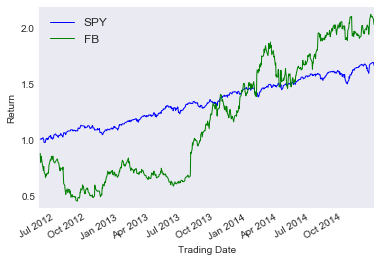

In [114]:
fb_data = master_data[['SPY', 'FB']].ix[I_START_DATE.strftime("%Y-%m-%d"):
                                        I_END_DATE.strftime("%Y-%m-%d")]
fb_data = fb_data.dropna()
fb_data = fb_data / fb_data.shift() - 1
fb_data = (fb_data + 1).cumprod()
ax = fb_data.plot()
ax.set_ylabel('Return')
ax.set_xlabel('Trading Date')
fig = ax.get_figure()
fig.savefig('fb_sp500.png', bbox_inches='tight')

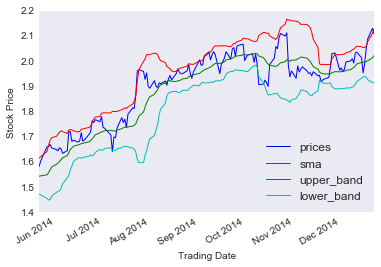

In [115]:
fb = fb_data[['FB']].rename(columns={'FB': 'prices'}).dropna()
fb = calc_stats(fb, days_out=5, dropna=True, add_params=True)
ax = fb[['prices', 'sma', 'upper_band', 'lower_band']].iloc[-150:, :].plot()
ax.set_ylabel('Stock Price')
ax.set_xlabel('Trading Date')
fig = ax.get_figure()
fig.savefig('fb_technical.png', bbox_inches='tight')

## Calculate the F1 Score of a given model
The f1 score is calcualted by

In [116]:
from sklearn.metrics import f1_score

def assess_model(prices, days_out=5, algorithm='rf', add_params=True):
    prices = prices.copy()
    prices = calc_stats(prices, days_out=days_out, dropna=True, add_params=add_params)
    data = prices.as_matrix()
    
    X_data = data[:, :-1]
    y_data = data[:, -1].astype(int)

    # Organize data into independent and dependent variables
    # Y data is shifted 5 days, we will aim to predict prices that are five
    # days into the future
    train_size = int(len(y_data) * 0.80)
    test_size = len(y_data) - train_size

    # Training data
    X_train = X_data[:train_size]
    y_train = y_data[:train_size]

    # Testing data
    X_test = X_data[train_size:]
    y_test = y_data[train_size:]

    # Train Model
    model = PriceModel(algorithm=algorithm)
    model.train(X_train, y_train)
    
    y_pred = model.predict(X_test)

    # Score using F1
    score = f1_score(y_test, y_pred)
    return score

## Find Best Performing Algorithm
Find the best perfomring algorithm by calculating the price change (increase/decrease) 5 days out.
The best peforming algorith will be used for final testing.

In [117]:
tickers = sp500_tickers
i_data = master_data[tickers].ix[I_START_DATE.strftime("%Y-%m-%d"):
                                 I_END_DATE.strftime("%Y-%m-%d")]

In [118]:
tickers = ['GOOG', 'KO', 'XOM', 'GS', 'UPS']
algorithms = ['gnb', 'svm', 'rf', 'lr', 'knn']
labels = ['Naive Bayes', 'SVM', 'Random Forest', 'Logistic Regression', 'KNN']
algo_performance = pd.DataFrame(columns=['ticker', 'score', 'algorithm', 'type'])

for ticker in tickers:
    prices = i_data[ticker].to_frame().rename(columns={ticker: 'prices'}).dropna()
    for i, algorithm in enumerate(algorithms):
        try:
            score_optimized = assess_model(prices, days_out=5,
                                           algorithm=algorithm,
                                           add_params=True)
            algo_performance.loc[len(algo_performance)] = [ticker, score_optimized, labels[i], 'optimized']
            
            score_original = assess_model(prices, days_out=5,
                                          algorithm=algorithm,
                                          add_params=False)
            algo_performance.loc[len(algo_performance)] = [ticker, score_original, labels[i], 'original']
            
        except Exception as e:
            pass

In [119]:
# The Performance of SVM (optimized vs original)
algo_performance[algo_performance['algorithm'] == 'SVM'][['score', 'type']].groupby('type').mean()

,score
type,
optimized,0.696374
original,0.667030


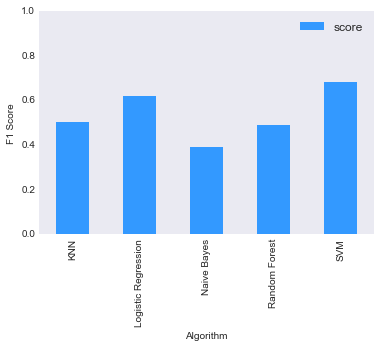

                        score
algorithm                    
KNN                  0.501101
Logistic Regression  0.619946
Naive Bayes          0.389740
Random Forest        0.487729
SVM                  0.681702


In [120]:
# Calculate the average scores for each algo
avg_score = algo_performance[['score', 'algorithm']].groupby('algorithm').mean()
ax = avg_score.plot(kind='bar', color='#3399ff', edgecolor="none")
ax.set_xlabel('Algorithm')
ax.set_ylabel('F1 Score')
ax.set_ylim([0.0,1.0])
fig = ax.get_figure()
fig.savefig('top_algo.png', bbox_inches='tight')
plt.show()
print avg_score

## Select the Most Predictive Stocks

The most predictive stocks are ones that have a highest F1 Score. We chose the top 10 stocks.

In [121]:
from sklearn.svm import SVC

tickers = sp500_tickers
perform = []
for ticker in tickers:
    prices = i_data[ticker].to_frame().rename(columns={ticker: 'prices'}).dropna()
    prices = calc_stats(prices, days_out=5, dropna=True, add_params=True)
    data = prices.as_matrix()

    X_data = data[:, :-1]
    y_data = data[:, -1]

    train_size = int(len(y_data) * 0.80)
    test_size = len(y_data) - train_size

    # Training data
    X_train = X_data[:train_size]
    y_train = y_data[:train_size]

    # Testing data
    X_test = X_data[train_size:]
    y_test = y_data[train_size:]

    clf = SVC(C=1, kernel='rbf')
    try:
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        # Score using F1
        score = f1_score(y_test, y_pred)
        perform.append((score, ticker))
    except Exception as e:
        print e
        pass

Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.
Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required.


In [122]:
# Selects the Top Performing Stocks
# as measured by F1 Score
perform.sort(key=lambda tup: tup[0], reverse=True)
top_picks = [v for k, v in perform[:10]]
print 'TOP PICKS'
top_picks.sort()
top_picks

TOP PICKS


['AVB', 'BXP', 'CVS', 'DPS', 'HBI', 'KR', 'LB', 'LUV', 'NAVI', 'SYF']

## Simulate Trading
The code below runs each stock in the Portfolio (top_picks) through the trading strategy. For each day in 2015 a prediction is made about whether  a stock price will increase or decrease. After the prediction, the loop iterates and the model is retrained using the previous day. Subsequently a new prediction is made.

In [123]:
tickers = sp500_tickers
t_data = master_data[tickers].ix[I_START_DATE.strftime("%Y-%m-%d"):
                                 END_DATE.strftime("%Y-%m-%d")]

In [124]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
DAYS_OUT = 5

dates = pd.date_range(I_START_DATE, END_DATE)
return_df = pd.DataFrame(index=dates)
trade_columns = [u'prices', u'std', u'sma', u'upper_band', u'lower_band', u'band_value',
       u'momentum', u'sma_50d', u'rsi', u'williams', u'macd', u'y', u'return',
       u'y_hat', u'profit']
trades = pd.DataFrame(columns=trade_columns)
total_return_df = pd.DataFrame(index=dates)
scores = []
for i, ticker in enumerate(top_picks):
    print ticker
    prices = t_data[ticker].to_frame().rename(columns={ticker: 'prices'}).dropna()
    data = calc_stats(prices, days_out=DAYS_OUT, dropna=False)
    return_df[ticker] = np.nan
    total_return_df[ticker] = np.nan
    
    for single_date in daterange(START_DATE, END_DATE):
        dt = single_date.strftime("%Y-%m-%d")
        dt_plus = (single_date + timedelta(1)).strftime("%Y-%m-%d")
    
        training_data = data[data.index < dt].dropna().as_matrix()
        testing_data = data[(data.index >= dt)
                            & (data.index <= dt)].as_matrix()

        if not testing_data.any():
            continue
        
        X_train = training_data[:, :-1]
        y_train = training_data[:, -1]

        X = testing_data[:, :-1]

        model = PriceModel(algorithm='svm')
        model.train(X_train, y_train)

        scores.append(model.score(X, testing_data[:, -1]))

        y_hat = model.predict(X)

        data_15 = data[(data.index >= dt)
                       & (data.index <= dt_plus)]
        data_15['return'] = (data_15['prices'] / data_15['prices'].shift() - 1)
        
        data_15 = data_15.dropna()
        data_15['y_hat'] = y_hat

        data_15 = data_15.fillna(0)
        data_15['profit'] = data_15['return'] * data_15['y_hat'] * 10000
        
        # Append to Trades dataframe
        data_15_copy = data_15.copy()
        data_15_copy['ticker'] = ticker
        trades = trades.append(data_15_copy)

        return_df[ticker].ix[dt] = (data_15['return'] * data_15['y_hat']).values
        total_return_df[ticker].ix[dt] = data_15['return'].values

AVB


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


BXP
CVS
DPS
HBI
KR
LB
LUV
NAVI
SYF


In [125]:
# F1 Score for Trading Period
t = trades[trades.index != 0]
trading_score = f1_score(t['y'], t['y_hat'])
print('F1 Score for Trading Period: %f' % trading_score)

F1 Score for Trading Period: 0.661422


## Calculate the Sharpe Ratios and Chart Performance
The code below calculates the Sharpe Ratio for the portfolio and SPY. Cummulative returns are then charted for both stocks along with an All Long Portfolio. The All Long Portfolio represents the returns of the Portfolio if we had held all stocks in the portfolio for the entire Trading Period, rather than buying and selling based on predictions. Comparing the All Long Portfolio with the machine learning optimized Portfolio, we can see that the All Long Portfolio did significantly worse. This reinforces the predictive power of machine learning when applied to stock market data.

In [126]:
# Calculate the return of the portfolio if it was equally weighted
port_return_ew = (total_return_df.dropna() * 1/30).sum(axis=1)
port_return_ew_cum = (port_return_ew + 1).cumprod()

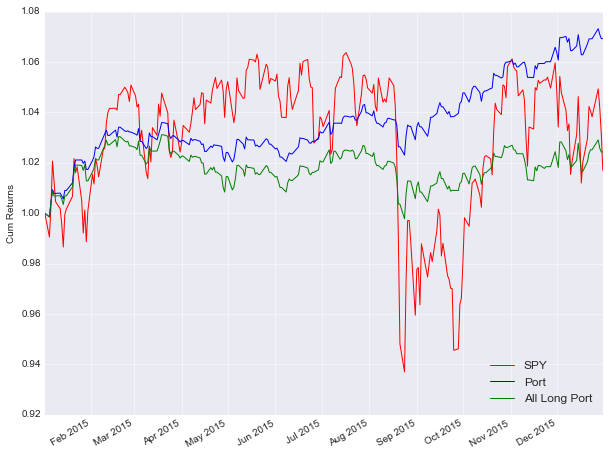

In [127]:
# Calculate performance metrics

# Gather SPY prices
spy_prices, spy_dates = fetch_data.fetch('SPY',
                                         datetime(2015, 1, 5),
                                         END_DATE)

# Calculate Portfolio Returns and Cummulative Returns
port_returns = (return_df.dropna() * 1/30).sum(axis=1)
port_cum = (port_returns + 1).cumprod().ix[:'2015-12-31']

# Calculate SPY Returns and Cummulative Returns
spy = pd.DataFrame(spy_prices, index=port_returns.index, columns=['SPY']).ix[:'2015-12-31']
spy = spy / spy.shift() - 1
spy = spy.fillna(0)
spy_cum = (spy + 1).cumprod()

RISK_FREE_RATE = 0.0

# Calculate SPY Sharpe Ratio
spy_total_return = (spy_cum['SPY'][-1] - 1)
spy_avg_return = spy['SPY'].mean()
spy_vol = spy['SPY'].std()
spy_sharpe = ((spy_avg_return - RISK_FREE_RATE)/ spy_vol) * math.sqrt(252)

# Calcualte Portfolio Sharpe Ratio
port_total_return = (port_cum[-1] - 1)
port_avg_return = port_returns.mean()
port_vol = port_returns.std()
port_sharpe = ((port_avg_return - RISK_FREE_RATE)/ port_vol) * math.sqrt(252)

# Plot returns
joint_returns = spy_cum.join(port_cum.to_frame(name='Port'))
joint_returns = joint_returns.join(port_return_ew_cum.to_frame(name='All Long Port'))
styles = ['r-','b-', 'g-']
fig, ax = plt.subplots(figsize=(10,8))
for col, style in zip(joint_returns.columns, styles):
    joint_returns[col].plot(style=style, ax=ax, label=col)
ax.grid(True)
ax.legend(loc=4)
ax.set_ylabel('Cum Returns')
fig.savefig('spy_vs_port.png', bbox_inches='tight')

In [128]:
print('Portfolio Return: %f' % port_total_return)
print('SPY Return: %f' % spy_total_return)
print('--------------------------')
print('Portfolio Sharpe Ratio: %f' % port_sharpe)
print('SPY Sharpe Ratio: %f' % spy_sharpe)
print('--------------------------')
print('Equal Weighted All Long Portfolio Return: %f' % (port_return_ew_cum[-1] - 1))

Portfolio Return: 0.069303
SPY Return: 0.017094
--------------------------
Portfolio Sharpe Ratio: 1.786883
SPY Sharpe Ratio: 0.186897
--------------------------
Equal Weighted All Long Portfolio Return: 0.030503
